In [74]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
from params_poly import p
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm

100%|██████████| 100/100 [00:00<00:00, 106.68it/s]


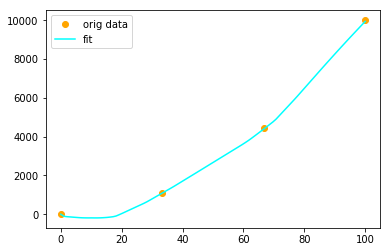

Loss: 1935.075562 after 99 batches


In [124]:
def poly(x):
    return x * x

def make_data():
    X = np.linspace(0, 100, 4)
    Y = np.apply_along_axis(poly, 0, X)
    return X, Y


def seed(p):
    # set random seed        
    np.random.seed(p.seed) 
    torch.manual_seed(p.seed)    
    random.seed(p.seed)
    
## network
class LinearNet(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size):
        # num_layers is number of weight matrices
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # for one layer nets
        if num_layers == 1:
            self.fc = nn.ModuleList([nn.Linear(input_size, output_size)])
        else:
            self.fc = nn.ModuleList([nn.Linear(input_size, hidden_size)])
            self.fc.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 2)])
            self.fc.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        y = x.view(-1, self.input_size)
        for i in range(len(self.fc) - 1):
            y = F.relu(self.fc[i](y))
        return self.fc[-1](y)
    
seed(p)
X, Y = make_data()
X_t, Y_t = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
model = LinearNet(4, input_size=1, hidden_size=512, output_size=1)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=1e-1) # wow Adam does way better
criterion =  torch.nn.MSELoss()
for batch_idx in tqdm(range(100)):
    # Reset gradients
    optimizer.zero_grad()

    # Forward pass
    loss = criterion(model(X_t), Y_t)

    # Backward pass
    loss.backward()

    # Apply gradients
    optimizer.step()

    
def plot_model(X, Y, model):
    Xgrid = Variable(torch.Tensor(np.linspace(np.min(X), np.max(X), 100)))
    yhat = model(Xgrid).data.numpy()
    plt.plot(X, Y, 'o', label='orig data', color='orange')
    plt.plot(Xgrid.data.numpy(), yhat, label='fit', color='cyan')
    plt.legend()

    
plot_model(X, Y, model)
plt.show()
print('Loss: {:.6f} after {} batches'.format(loss.data[0], batch_idx))